In [1]:
import numpy as np
import os
import math

import matplotlib.pyplot as plt

plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize


import optimalrcs,metrics,plots

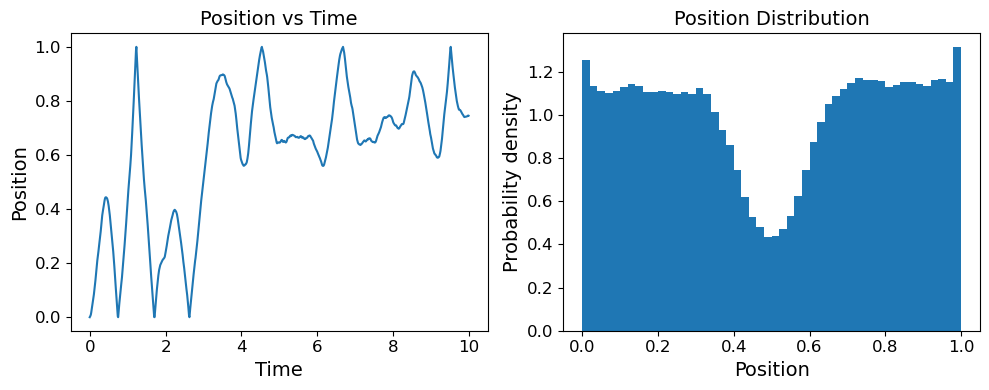

#=1000, xent=0.256028, mse=0.0743503, sdzq=20.9504, dzq=51.2042, dr2=3437.19, auc=0.958059, |dx|=0.409887, time=12.9112
#=2000, xent=0.253898, mse=0.0737152, sdzq=17.9926, dzq=44.6927, dr2=3311.55, auc=0.958699, |dx|=0.0152118, time=25.5242
#=3000, xent=0.250756, mse=0.0732301, sdzq=7.28683, dzq=23.5782, dr2=3281.6, auc=0.959951, |dx|=0.0229837, time=12.6041
#=4000, xent=0.250706, mse=0.0732275, sdzq=6.52046, dzq=21.178, dr2=3275.23, auc=0.959972, |dx|=0.00231702, time=25.2173
#=5000, xent=0.250662, mse=0.0732192, sdzq=5.96529, dzq=19.0092, dr2=3276.75, auc=0.959997, |dx|=0.00127429, time=37.8457
#=6000, xent=0.250628, mse=0.0732168, sdzq=5.90201, dzq=18.6161, dr2=3275.85, auc=0.960009, |dx|=0.000934609, time=50.4658
#=7000, xent=0.250608, mse=0.0732125, sdzq=5.78815, dzq=17.8531, dr2=3274.61, auc=0.960021, |dx|=0.000864367, time=63.0883
#=8000, xent=0.250575, mse=0.0732084, sdzq=5.5558, dzq=17.7767, dr2=3279.83, auc=0.96003, |dx|=0.000659887, time=75.7061
#=9000, xent=0.250565, mse=0.

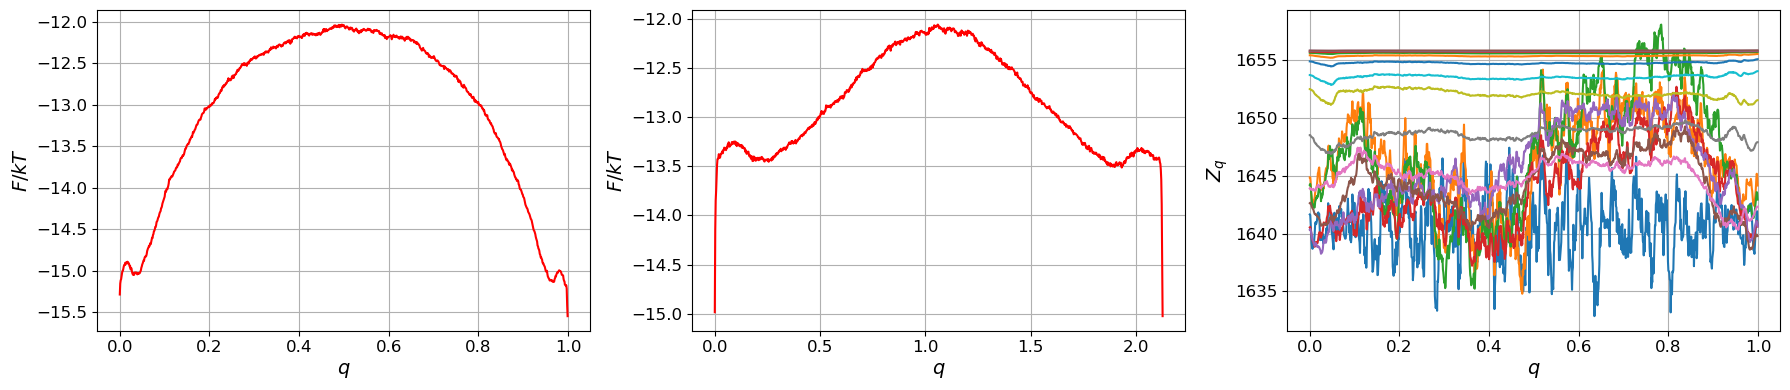

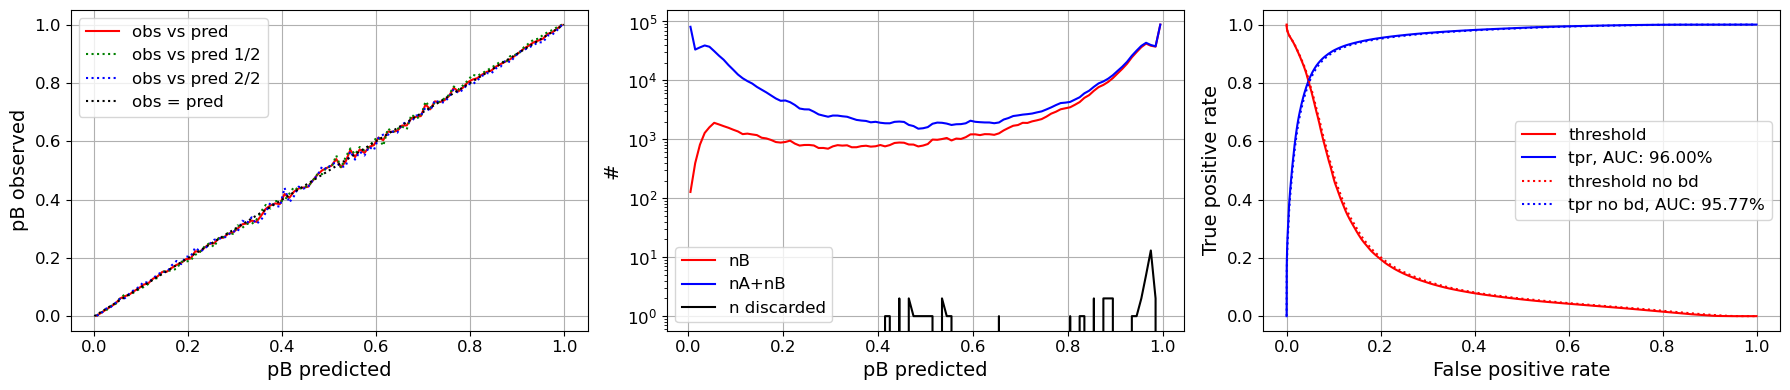

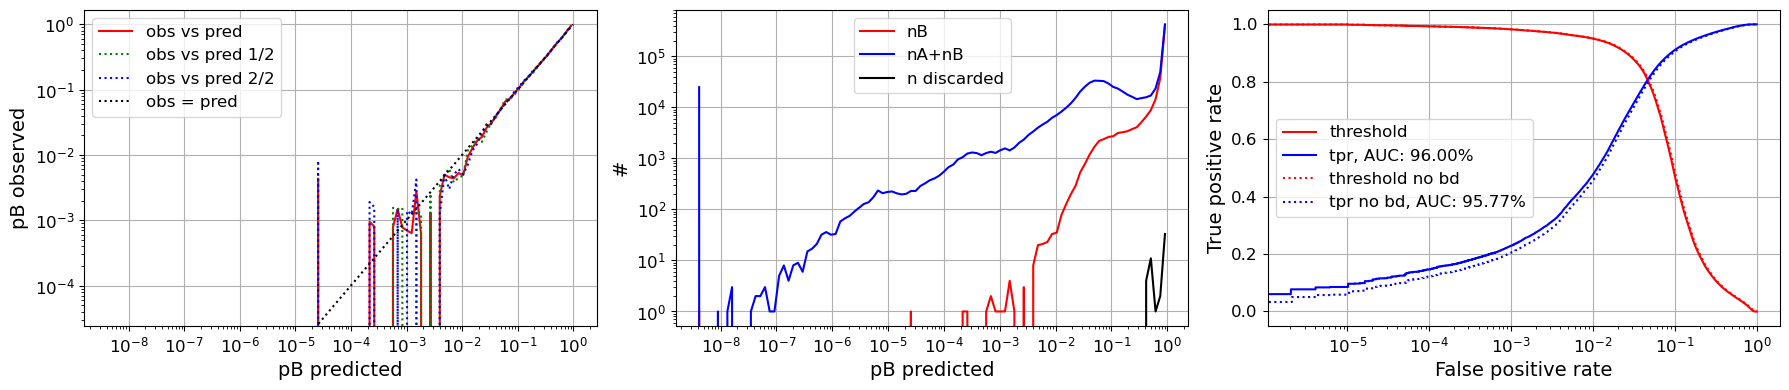

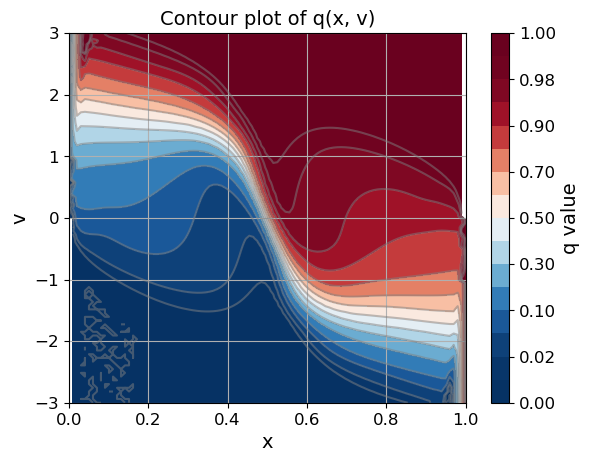

In [2]:
# Parameters
m = 1.0  # mass
gamma = 1.0  # friction coefficient
k_B = 1.0  # Boltzmann constant
T = 1.0  # temperature
dt = 0.01  # time step
num_steps = 1000000  # number of steps
x0 = 0.0  # initial position
v0 = 0.0  # initial velocity

# Potential function U(x)
def potential(x):
    return math.exp(-(x-0.5)**2/0.01)

# Gradient of the potential (force)
def force(x):
    return (x-0.5)*2/0.01*math.exp(-(x-0.5)**2/0.01)

# Initialize arrays to store positions and velocities
positions = np.zeros(num_steps)
velocities = np.zeros(num_steps)

# Initial conditions
positions[0] = x0
velocities[0] = v0


np.random.seed(0)
# Simulation loop
for i in range(1, num_steps):
    x = positions[i-1]
    v = velocities[i-1]
    
    # Calculate forces
    F = force(x)
    
    # Generate random noise
    xi = np.random.normal(0, 1)
    
    # Update velocity and position using the Euler-Maruyama method
    v = v + (-gamma * v + F / m) * dt + np.sqrt(2 * gamma * k_B * T / m) * xi * np.sqrt(dt)
    x = x + v * dt
    
    # Apply boundary conditions (reflective walls)
    if x < 0:
        x = 0
        v = -v  # Reflect velocity
    elif x > 1:
        x = 1
        v = -v  # Reflect velocity
    
    # Store positions and velocities
    positions[i] = x
    velocities[i] = v

# Plot the results
time = np.linspace(0, num_steps * dt, num_steps)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(time[:1000], positions[:1000])
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position vs Time')

plt.subplot(1, 2, 2)
plt.hist(positions, bins=50, density=True)
plt.xlabel('Position')
plt.ylabel('Probability density')
plt.title('Position Distribution')

plt.tight_layout()
plt.show()


i_traj=np.ones_like(positions)
t_traj=np.asarray(range(len(positions)))
from scipy.interpolate import griddata

def qxv(q,x,v):

    xi = np.linspace(0, 1, 100)
    vi = np.linspace(-3, 3, 100)
    xi, vi = np.meshgrid(xi, vi)

    qi = griddata((x, v), q, (xi, vi), method='cubic')
    qi = np.clip(qi, 0, 1)
    levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]

    
    # Create the contour plot with specified contour lines
    contour = plt.contourf(xi, vi, qi, levels=levels, cmap="RdBu_r")
    contour_lines = plt.contour(xi, vi, qi, levels=levels, colors='grey', alpha=0.5)

    plt.colorbar(contour, label='q value')
    plt.xlabel('x')
    plt.ylabel('v')
    plt.title('Contour plot of q(x, v)')
    plt.grid()
    plt.show()
    
    
def comp_y(): return positions

history=[0,1]
yr_type=['y(t-d),y(t)']

q=optimalrcs.CommittorNE(boundary0=positions<0.01,boundary1=positions>0.99, i_traj=i_traj, t_traj=t_traj)
np.random.seed(0)
optimalrcs.envelope_scale=1000000
q.fit_transform(comp_y,history_delta_t=history,gamma=0,max_iter=2000,history_type=yr_type, history_shift_type='r(t)',delta_r2_max_change_allowed=10000)
optimalrcs.envelope_scale=0.01
q.fit_transform(comp_y,history_delta_t=history,gamma=0,max_iter=10000,history_type=yr_type, history_shift_type='r(t)')

q.plots_feps(delta_t_sim=0.01)
q.plots_obs_pred()
q.plots_obs_pred(log_scale=True)
plt.show()
qxv(q.r_traj.get(),positions,velocities)

#=1000, xent=0.253683, mse=0.0735405, sdzq=29.2138, dzq=78.5072, dr2=3351.68, auc=0.958989, |dx|=0.405369, time=12.5386
#=2000, xent=0.25261, mse=0.0731968, sdzq=27.8735, dzq=83.5885, dr2=3256.41, auc=0.959492, |dx|=0.0140864, time=25.0779
#=3000, xent=0.249081, mse=0.0727193, sdzq=8.74778, dzq=30.5829, dr2=3263.36, auc=0.96063, |dx|=0.0225755, time=12.5459
#=4000, xent=0.248996, mse=0.0727104, sdzq=9.01284, dzq=29.7944, dr2=3261.89, auc=0.96067, |dx|=0.00301134, time=25.0619
#=5000, xent=0.248892, mse=0.0726988, sdzq=8.51777, dzq=25.3578, dr2=3260.7, auc=0.960697, |dx|=0.00177949, time=37.5812
#=6000, xent=0.248868, mse=0.0726918, sdzq=8.29489, dzq=24.2976, dr2=3262.31, auc=0.960696, |dx|=0.00154118, time=50.1282
#=7000, xent=0.248857, mse=0.0726855, sdzq=8.18182, dzq=23.1667, dr2=3260.1, auc=0.960716, |dx|=0.00114286, time=62.6724
#=8000, xent=0.248823, mse=0.0726838, sdzq=7.25977, dzq=21.4186, dr2=3261.02, auc=0.960721, |dx|=0.000929098, time=75.2174
#=9000, xent=0.248809, mse=0.072

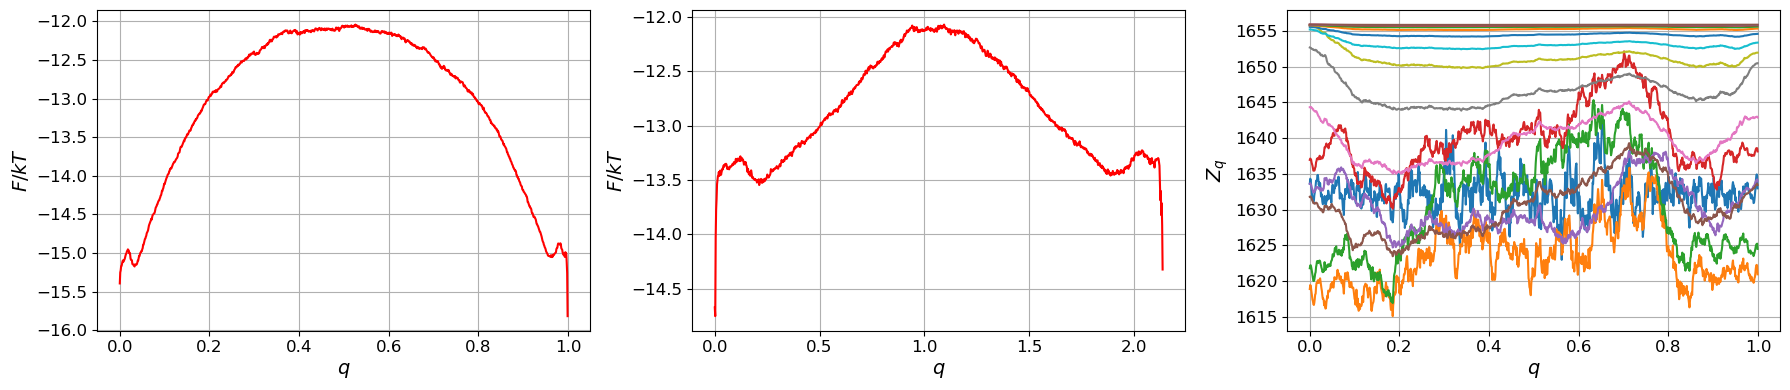

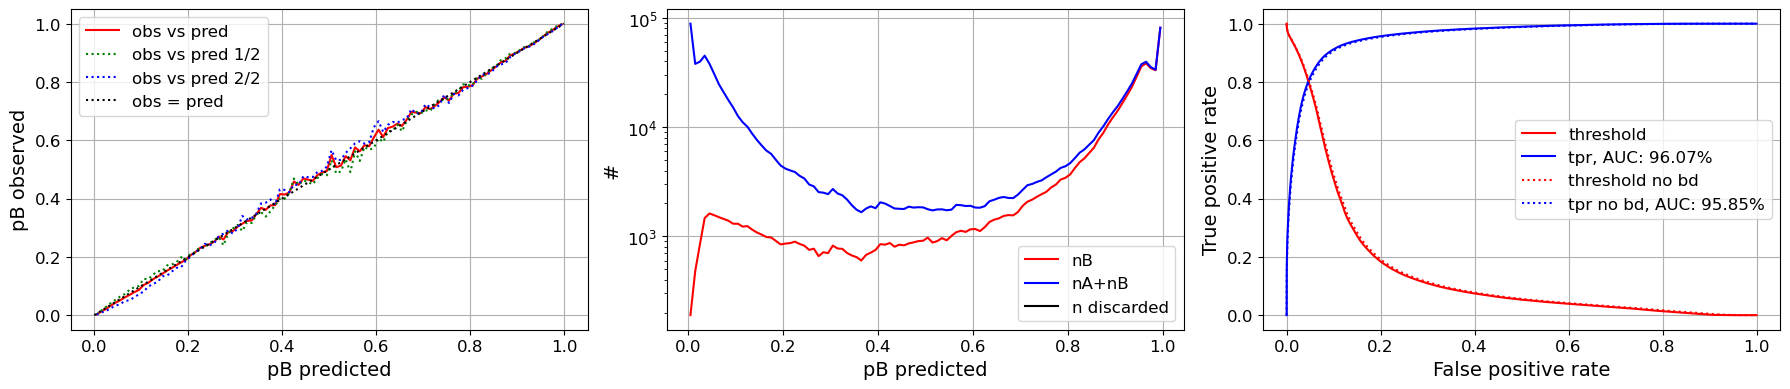

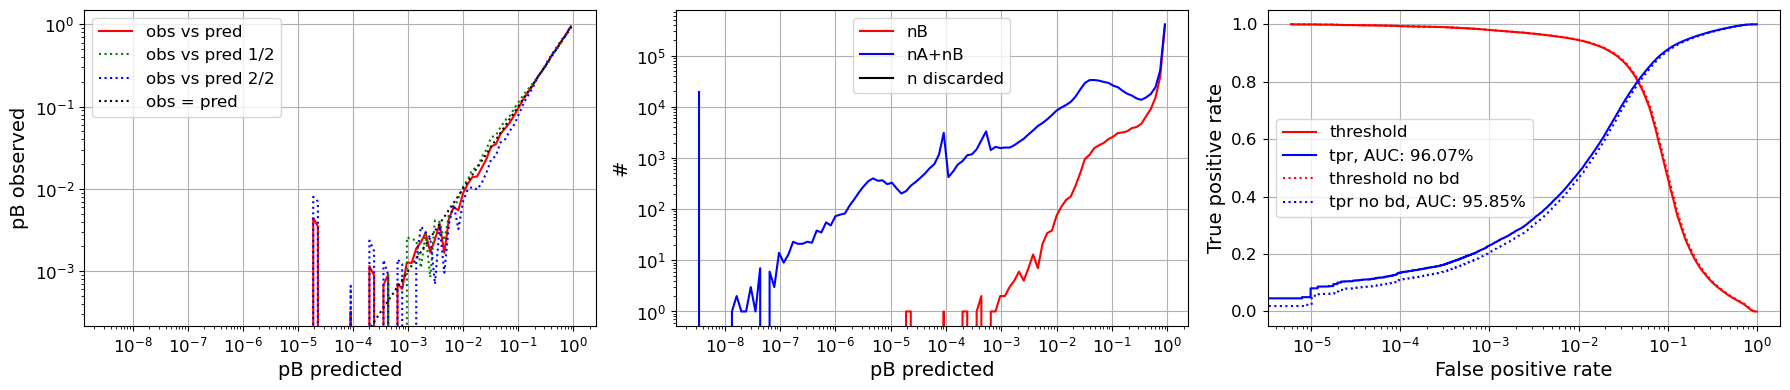

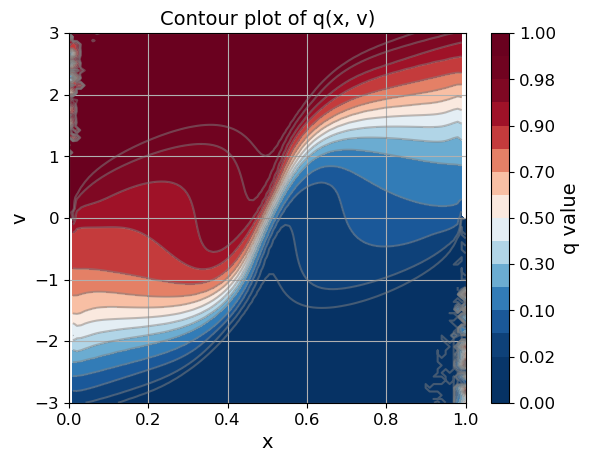

In [3]:
positions_r=positions[::-1].copy()


def comp_y(): return positions_r

history=[0,1]
yr_type=['y(t-d),y(t)']

q_r=optimalrcs.CommittorNE(boundary0=positions_r>0.99,boundary1=positions_r<0.01, i_traj=i_traj, t_traj=t_traj)
np.random.seed(0)
optimalrcs.envelope_scale=1000000
q_r.fit_transform(comp_y,history_delta_t=history,gamma=0,max_iter=2000,history_type=yr_type, history_shift_type='r(t)',delta_r2_max_change_allowed=10000)
optimalrcs.envelope_scale=0.01
q_r.fit_transform(comp_y,history_delta_t=history,gamma=0,max_iter=10000,history_type=yr_type, history_shift_type='r(t)')

q_r.plots_feps(delta_t_sim=0.01)
q_r.plots_obs_pred()
q_r.plots_obs_pred(log_scale=True)
plt.show()
qxv(q_r.r_traj.get()[::-1],np.roll(positions,-1),np.roll(velocities,-1))

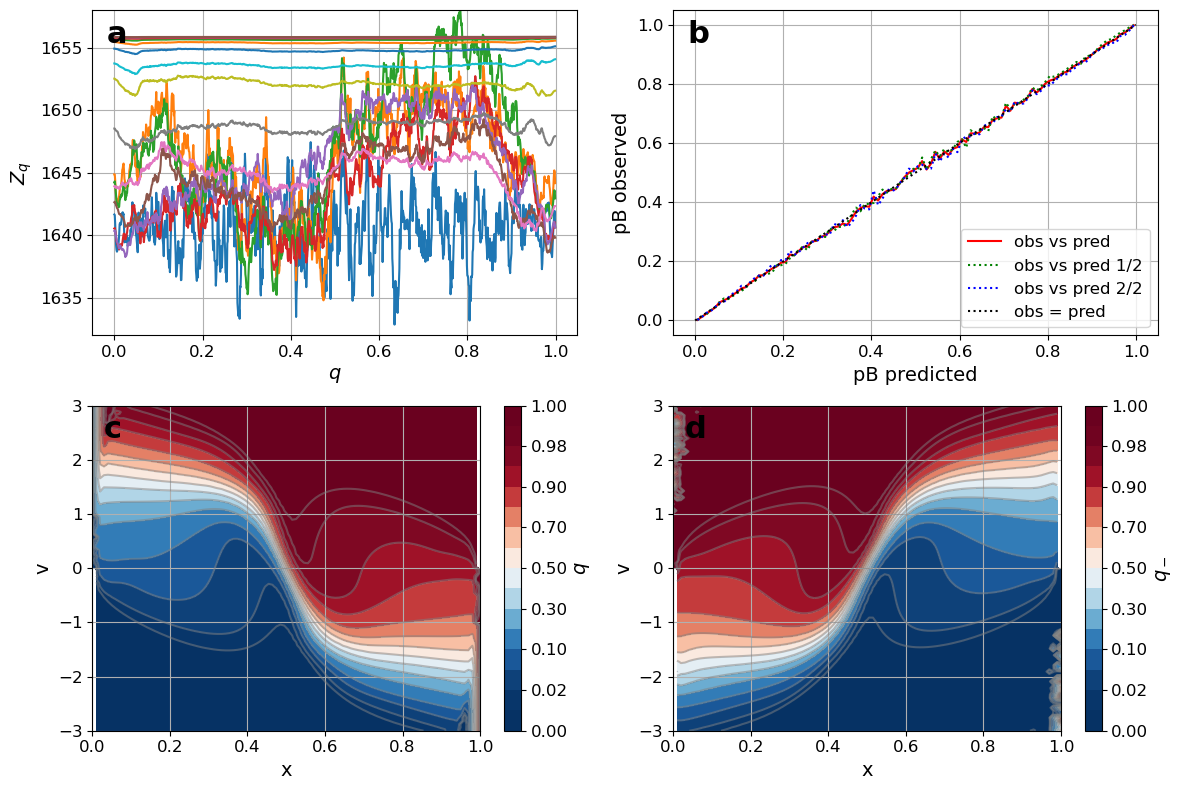

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
letters = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axes.flat):
    ax.text(0.03, 0.97, letters[i], transform=ax.transAxes, fontsize=22, fontweight='bold', va='top')

def qxv(q,x,v,ax,label='q'):

    xi = np.linspace(0, 1, 100)
    vi = np.linspace(-3, 3, 100)
    xi, vi = np.meshgrid(xi, vi)

    qi = griddata((x, v), q, (xi, vi), method='cubic')
    qi = np.clip(qi, 0.0001, 1-0.0001)
    levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]

    
    # Create the contour plot with specified contour lines
    contour = ax.contourf(xi, vi, qi, levels=levels, cmap="RdBu_r")
    contour_lines = ax.contour(xi, vi, qi, levels=levels, colors='grey', alpha=0.5)
    fig.colorbar(contour, ax=ax, label=label)
    ax.set(xlabel='x',ylabel='v')
    ax.grid()

qxv(q.r_traj.get(),positions,velocities,axes[1,0],label='$q$')
qxv(q_r.r_traj.get()[::-1],np.roll(positions,-1),np.roll(velocities,-1),axes[1,1],label='$q_-$')

plots.plot_zq(axes[0,0], q.r_traj, q.b_traj, q.i_traj, q.future_boundary, q.past_boundary)
axes[0,0].set(ylim=(1635-3,1655+3))
plots.plot_obs_pred_q(axes[0,1], q.r_traj, q.future_boundary)
axes[0,1].legend(loc='lower right')
fig.tight_layout()
plt.savefig("Fig5.pdf",format='pdf')